In [136]:
import os
import csv

import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import NearestNeighbors, LocalOutlierFactor
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

import keras
import tensorflow as tf
import random as python_random
from keras import layers
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping
from keras import backend as K

import pandas.io.sql as sqlio
import psycopg2
import getpass

import matplotlib.pyplot as plt

In [137]:
tf.test.is_gpu_available()

True

## 1. Load data

In [138]:
# Define MIMIC data path
data_path = '../mimic_data/'

# Load training data
train_pos = pd.read_csv(data_path+'train_pos.txt')
train_neg = pd.read_csv(data_path+'train_neg.txt')

# Add target class label
train_pos['survival'] = [1 for i in range(train_pos.shape[0])]
train_neg['survival'] = [0 for i in range(train_neg.shape[0])]

# Set static feature names
static_feature_names = ['gender', 'dob']

Concatinate the drug and procedure codes into a single feature

In [139]:
train_neg['events'] = train_neg['drug_events'] + " " + train_neg['procedure_codes']
train_pos['events'] = train_pos['drug_events'] + " " + train_pos['procedure_codes']

In [140]:
# Concat into one data frame; and reorder it
train = pd.concat([train_pos, train_neg]).reset_index()
train_reordered = train.sample(frac=1, random_state=3)

In [141]:
train_reordered

,index,subject_id,drug_events,procedure_codes,gender,dob,survival,events
3249,431,49599,225828 226364 225975 225907 225975 225850 2259...,3259 4029 8674 3420,F,2067-11-16,0,225828 226364 225975 225907 225975 225850 2259...
1754,1754,74509,221744 226364 225828 221744 221668 225974 2259...,4611 4869,F,2030-02-19,1,221744 226364 225828 221744 221668 225974 2259...
3139,321,42769,225942 221668 227522 225166 226361 221668 2259...,9671 9604 3891,M,1895-08-29,0,225942 221668 227522 225166 226361 221668 2259...
2491,2491,91910,225828 226375 226364 225168 225828 225975 2258...,3249 3479 4011 3323 0390 9605,M,2064-02-14,1,225828 226375 226364 225168 225828 225975 2258...
3914,1096,91616,226361 225166 225798 225883 225906 225883 2257...,5185 5114 5187 3897 9239 9359 5110 9755 9705,M,2107-02-08,0,226361 225166 225798 225883 225906 225883 2257...
...,...,...,...,...,...,...,...,...
3000,182,28600,220970 220970 220970 225168 225168 225168 2251...,9229 3893 3893,M,2026-11-11,0,220970 220970 220970 225168 225168 225168 2251...
1667,1667,72170,220950 226361 221794 225851 225879 227694 2217...,8191,F,2038-02-24,1,220950 226361 221794 225851 225879 227694 2217...
3321,503,53735,221668 221906 226361 225152 222168 222168 2258...,9671 9604 3893 9960,F,2075-01-08,0,221668 221906 226361 225152 222168 222168 2258...
1688,1688,72690,221833 221833 225166 221833 221749 221749 2217...,3891,M,2116-04-11,1,221833 221833 225166 221833 221749 221749 2217...


In [142]:

X_train_events, X_train_static, y_train = train_reordered['events'], train_reordered[static_feature_names], train_reordered['survival']

In [143]:
X_train_events.head()

3249    225828 226364 225975 225907 225975 225850 2259...
1754    221744 226364 225828 221744 221668 225974 2259...
3139    225942 221668 227522 225166 226361 221668 2259...
2491    225828 226375 226364 225168 225828 225975 2258...
3914    226361 225166 225798 225883 225906 225883 2257...
Name: events, dtype: object

In [144]:
# Load validation data
validation_pos = pd.read_csv(data_path+'validation_pos.txt')
validation_neg = pd.read_csv(data_path+'validation_neg.txt')

# Add target class
validation_pos['survival'] = [1 for i in range(validation_pos.shape[0])]
validation_neg['survival'] = [0 for i in range(validation_neg.shape[0])]

validation_neg['events'] = validation_neg['drug_events'] + " " + validation_neg['procedure_codes']
validation_pos['events'] = validation_pos['drug_events'] + " " + validation_pos['procedure_codes']

In [145]:
validation_pos

,subject_id,drug_events,procedure_codes,gender,dob,survival,events
0,90776,226363 221662 225154 225154 221662 221662 2216...,0066 3606 3723 8856 3778 0046 0040 8191,F,2033-10-18,1,226363 221662 225154 225154 221662 221662 2216...
1,1709,225798 225975 227694 225975 221668 221744 2220...,3995 5491 3995 3995 3995 3995 3995 3995,F,2063-08-10,1,225798 225975 227694 225975 221668 221744 2220...
2,40514,225152 222056 225152 225152 221749 222168 2263...,3614 3723 3615 8856 3961,M,2129-12-24,1,225152 222056 225152 225152 221749 222168 2263...
3,67696,223262 222011 222011 223262 225168 225170 2251...,4513 4524 4523 8847,F,2127-06-29,1,223262 222011 222011 223262 225168 225170 2251...
4,71871,225910 225168 225168 226361 225910 221456 2258...,4523 4513 4519,F,2064-05-25,1,225910 225168 225168 226361 225910 221456 2258...
...,...,...,...,...,...,...,...
195,97552,225828 225847 225884 223258 225847 225910 2251...,8412 8385 4443 9907 9904 3893,M,2113-06-21,1,225828 225847 225884 223258 225847 225910 2251...
196,52803,222168 227522 225166 227523 222056 222011 2251...,3522 3722 3961 8852 8855,F,2070-12-29,1,222168 227522 225166 227523 222056 222011 2251...
197,42919,226361 225798 221833 221833 225975 227694 2259...,8605 3895 8867 3897 8604 3995,M,2100-11-24,1,226361 225798 221833 221833 225975 227694 2259...
198,60046,222168 221749 225828 225166 227522 222011 2275...,3512 3571 3961,F,2068-05-01,1,222168 221749 225828 225166 227522 222011 2275...


In [146]:
train_neg['events'] = train_neg['drug_events'] + " " + train_neg['procedure_codes']
train_pos['events'] = train_pos['drug_events'] + " " + train_pos['procedure_codes']

In [147]:
validation = pd.concat([validation_pos, validation_neg]).reset_index()
validation_reordered = validation.sample(frac=1, random_state=3)


X_val_events, X_val_static, y_val = validation_reordered["events"],validation_reordered[static_feature_names], validation_reordered['survival']

In [148]:
X_val_events.head()

376    225827 226375 225884 225974 223258 225907 2258...
16     225910 225855 220970 220970 225168 225168 2209...
365            221794 225828 221794 225834 5551 3932 403
82     221986 226361 225166 227522 225166 227522 2217...
107    226453 225799 225883 223262 225975 225799 2209...
Name: events, dtype: object

### Data preprocessing

#### 1.1 Conver all the events into sequence (token) ids

In [149]:
# Set the vocab size and max sequence lenght
vocab_size = 1100 #(max vocab id=1024 in the training data)
max_seq_length = 74 #(the maximum sequence length in training/testing data)

In [150]:
# Use a text tokenizer to convert events
tokenizer = Tokenizer(num_words = vocab_size)
tokenizer.fit_on_texts(X_train_events)

In [151]:
X_train_sequences = tokenizer.texts_to_sequences(X_train_events)
X_val_sequences = tokenizer.texts_to_sequences(X_val_events)

In [152]:
# Before texts_to_sequences()
print(f'Before texts_to_sequences():\n {X_train_events.iloc[0]}\n')

# After texts_to_sequences()
print(f'After texts_to_sequences():\n {X_train_sequences[0]}')

Before texts_to_sequences():
 225828 226364 225975 225907 225975 225850 225907 225975 225850 225168 225907 225828 225975 225828 221794 225975 227523 222011 225975 3259 4029 8674 3420

After texts_to_sequences():
 [5, 31, 3, 33, 3, 21, 33, 3, 21, 13, 33, 5, 3, 5, 10, 3, 20, 12, 3, 379, 495, 380, 328]


#### 1.2 Padding converted sequences

In [153]:
# Pad X_train_sequences and X_val_sequences
X_train_padded = sequence.pad_sequences(X_train_sequences, maxlen=max_seq_length, padding='post')
X_val_padded = sequence.pad_sequences(X_val_sequences, maxlen=max_seq_length, padding='post')

In [154]:
X_train_padded.shape

(4039, 74)

In [155]:
X_val_padded.shape

(400, 74)

In [156]:
X_val_padded

array([[198, 116,  29, ...,   0,   0,   0],
       [ 15,  45,  40, ...,   0,   0,   0],
       [ 10,   5,  10, ...,   0,   0,   0],
       ...,
       [ 48,  14,  10, ...,   0,   0,   0],
       [ 14,  28,  12, ...,   0,   0,   0],
       [227,  10,  10, ...,   0,   0,   0]])

## 2. Train the main LSTM model for survival prediction

In [157]:
# For plotting the accuracy/loss of keras models
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

In [158]:
# Fix the random seeds to get consistent models
## ref: https://keras.io/getting_started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development
seed_value = 3

os.environ['PYTHONHASHSEED']=str(seed_value)

# The below is necessary for starting Numpy generated random numbers in a well-defined initial state.
np.random.seed(seed_value)

# The below is necessary for starting core Python generated random numbers in a well-defined state.
python_random.seed(seed_value)

# The below set_seed() will make random number generation
tf.random.set_seed(seed_value)

# configure a new global `tensorflow` session
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

def reset_seeds(seed_value=3):
    os.environ['PYTHONHASHSEED']=str(seed_value)
    np.random.seed(seed_value) 
    python_random.seed(seed_value)
    tf.random.set_seed(seed_value)

reset_seeds() 

In [159]:
# Define the early stopping criteria
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3)

In [160]:
# Define the model structure
# Input for variable-length sequences of integers
inputs = keras.Input(shape=(None,), dtype="int32")

# Embed each integer in a 128-dimensional vector
x = layers.Embedding(vocab_size, 128)(inputs)

# Add 2 bidirectional LSTMs
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(64))(x)
x = layers.Dense(64)(x)
x = layers.Dense(64)(x)

# Add a classifier
outputs = layers.Dense(1, activation="sigmoid")(x)
main_model = keras.Model(inputs, outputs)

main_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_1 (Embedding)     (None, None, 128)         140800    
                                                                 
 bidirectional_2 (Bidirectio  (None, None, 128)        98816     
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dense_4 (Dense)             (None, 64)                4160

In [161]:
main_model.compile("adam", "binary_crossentropy", metrics=["accuracy"])

reset_seeds()
model_history = main_model.fit(
    X_train_padded, 
    y_train, 
    epochs=30, 
    batch_size=64, 
    validation_data=(X_val_padded, y_val), 
    callbacks=[early_stopping]
    )

Epoch 1/30
64/64 [==============================] - 11s 69ms/step - loss: 0.5749 - accuracy: 0.7029 - val_loss: 0.6873 - val_accuracy: 0.5650
Epoch 2/30
64/64 [==============================] - 3s 41ms/step - loss: 0.5006 - accuracy: 0.7480 - val_loss: 0.5758 - val_accuracy: 0.6800
Epoch 3/30
64/64 [==============================] - 3s 40ms/step - loss: 0.4628 - accuracy: 0.7735 - val_loss: 0.6189 - val_accuracy: 0.6725
Epoch 4/30
64/64 [==============================] - 3s 40ms/step - loss: 0.4355 - accuracy: 0.8047 - val_loss: 0.7104 - val_accuracy: 0.6525
Epoch 5/30
64/64 [==============================] - 3s 40ms/step - loss: 0.4119 - accuracy: 0.8089 - val_loss: 0.6867 - val_accuracy: 0.6400


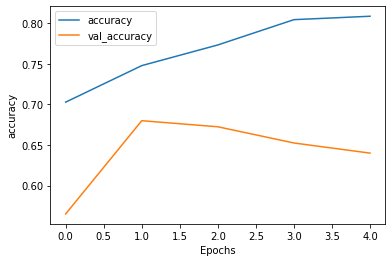

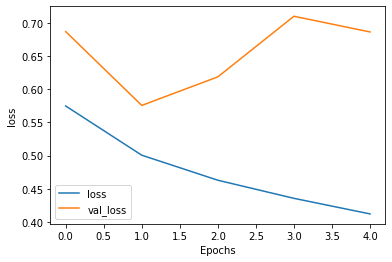

In [162]:
# Visualize the training/validation accuracy and loss
plot_graphs(model_history, "accuracy")
plot_graphs(model_history, "loss")

In [163]:
# Get the predicted target class: if pred > 0.5, then y_pred = 1; else, y_pred = 0
y_pred = np.array([1 if pred > 0.5 else 0 for pred in main_model.predict(X_val_padded)])

In [164]:
# Calculate the validation accuracy
validation_acc = sum(y_pred == y_val)/len(y_val)
validation_acc

0.64

In [165]:
# Get the confusion matrix
confusion_matrix_df = pd.DataFrame(
        confusion_matrix(y_true=y_val, y_pred=y_pred, labels=[1, 0]),
        index=['True:pos', 'True:neg'], 
        columns=['Pred:pos', 'Pred:neg']
    )
confusion_matrix_df

,Pred:pos,Pred:neg
True:pos,181,19
True:neg,125,75


In [166]:
# Counts of positive and negative predictions
pd.value_counts(y_pred)

1    306
0     94
dtype: int64

## 3. Get the negative predictions from LSTM, for counterfactual explanations

In [167]:
# Get these instances of negative predictions
X_pred_negative = X_val_padded[y_pred == 0]

In [168]:
X_pred_negative.shape

(94, 74)

#### Export as the desired input format of the DRG framework

In [169]:
# Convert negatively predicted instances back to medical event form
original_event_sequences = tokenizer.sequences_to_texts(X_pred_negative)

In [170]:
original_event_sequences[:5]

['225799 226453 225884 226453 225799 225851 225799 225884 225910 225837 226453 225799 227690 225799 226453 225799 225884 226453 227690 225910 226453 225799 225884 225798 225799 226089 226089 226089 225851 225798 0331 3995 966 3893',
 '226089 220995 225835 3323 8844 9929 9229',
 '221749 225828 221668 226361 225828 221749 221749 225884 225893 225907 225798 225828 225828 225893 225884 221749 221668 225907 221668 225884 225828 221668 225893 221668 221668 221668 225884 221668 221749 225893 225907 225828 225893 225828 225884 225893 225828 225907 225893 225166 225798 225859 225799 225884 9671 3891 3893',
 '226361 225893 225975 225893 226089 225166 226089 225166 225893 225975 225975 225798 225851 225828 223262 223262 223262 225975 9702 9390 966 3893',
 '225168 225168 225893 223258 225168 223258 225893 225893 223258 225798 225168 225893 223258 223258 225798 223258 225798 221794 223258 221744 221668 221744 221668 221668 221668 221668 223258 225863 221906 221906 225893 221906 225168 222011 227523

In [171]:
pd.DataFrame(original_event_sequences).to_csv(path_or_buf='../mimic_data/test_neg.txt', index=False, header=False, sep=' ', quoting = csv.QUOTE_NONE, escapechar = ' ')

Here, we need to use the inference script from the DRG framework (instructions in the README file) to modify those 110 negative predictions into positive instances. After that, we import the transformed results as below.

### 3.1 DeleteOnly model results

In [172]:
# Load the transformed data
results_path = '../drg_preds_delete/'
trans_results_delete = pd.read_csv(results_path+'preds', header=None)

In [173]:
X_test_sequences = tokenizer.texts_to_sequences(trans_results_delete[0])

X_test_padded = sequence.pad_sequences(X_test_sequences, maxlen=max_seq_length, padding='post')

### 3.2 DeleteAndRetrieve model results

In [174]:
# Load the transformed data
# TODO change this directory
delete_generate_results_path = '../drg_preds_delete/'
delete_generate_results = pd.read_csv(delete_generate_results_path+'preds', header=None)

In [175]:
X_test_sequences2 = tokenizer.texts_to_sequences(delete_generate_results[0])

X_test_padded2 = sequence.pad_sequences(X_test_sequences2, maxlen=max_seq_length, padding='post')

### 3.3 Use 1NN baseline method to modify the negatively predicted instances

In [176]:
# Fit an unsupervised 1NN with all the positive sequences, using 'hamming' distance
nn_model = NearestNeighbors(n_neighbors=1, metric='hamming')
target_label = 1
X_target_label = X_train_padded[y_train == target_label]

nn_model.fit(X_target_label)

NearestNeighbors(metric='hamming', n_neighbors=1)

In [177]:
# Find the closest neighbor (positive sequence) with the minimum 'hamming' distance, take it as a counterfactual
closest = nn_model.kneighbors(X_pred_negative, return_distance=False)
trans_results_nn = X_target_label[closest[:, 0]]

trans_results_nn[0]

array([ 27,  46,  27,  46,  46,  27,  27,  46,  46,  27,  15,  27,  27,
         9,  27,  27,  27,  35,  27,  27,  27,   9,  82,  82,  82,   9,
        82,   9,  35,  15,  79,  36,  70, 140,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0])

In [178]:
# Rename 'trans_results_nn' to 'X_test_padded3' for result comparison
X_test_padded3 = trans_results_nn

### 3.4 Convert transformed results to event sequence format

In [179]:
# Convert transformed sequences back to the form of original event sequences
trans_event_sequences1 = tokenizer.sequences_to_texts(X_test_padded)
trans_event_sequences2 = tokenizer.sequences_to_texts(X_test_padded2)
trans_event_sequences3 = tokenizer.sequences_to_texts(X_test_padded3)

## 4. Results comparison

### 4.1 Comparison between fraction of valid CFs (i.e. successfully generated counterfactuals)

In [180]:
# Get the total counts 
test_size = X_pred_negative.shape[0]

In [181]:
# Fraction of valid transformed sequences, for DeleteOnly
fraction_success = np.sum(main_model.predict(X_test_padded) > 0.5)/test_size
print(round(fraction_success, 4))

1.6489


In [182]:
# For DeleteAndRetrieve
fraction_success2 = np.sum(main_model.predict(X_test_padded2) > 0.5)/test_size
print(round(fraction_success2, 4))

1.6489


In [183]:
# For 1NN modification
fraction_success3 = np.sum(main_model.predict(X_test_padded3) > 0.5)/test_size
print(round(fraction_success3, 4))

0.8723


### 4.2 Local outlier factor (LOF score)

In [184]:
# Fit the model for novelty detection (novelty=True), in order to get LOF score
clf = LocalOutlierFactor(n_neighbors=20, novelty=True, contamination=0.1)
clf.fit(X_train_padded)

LocalOutlierFactor(contamination=0.1, novelty=True)

In [185]:
# Get the LOF score for leave-out validation data
y_pred_val = clf.predict(X_val_padded)

n_error_val = y_pred_val[y_pred_val == -1].size

In [186]:
validation_size = X_val_padded.shape[0]
outlier_score_val = n_error_val/validation_size

outlier_score_val

0.075

In [187]:
# Get the LOF score for DeleteOnly results
y_pred_test = clf.predict(X_test_padded)
n_error_test = y_pred_test[y_pred_test == -1].size

outlier_score_test = n_error_test / test_size
print(round(outlier_score_test, 4))

0.0957


In [188]:
# Get the outlier score for DeleteAndRetrieve results
y_pred_test2 = clf.predict(X_test_padded2)
n_error_test2 = y_pred_test2[y_pred_test2 == -1].size

outlier_score_test2 = n_error_test2 / test_size
print(round(outlier_score_test2, 4))

0.0957


In [189]:
# Outlier score for 1NN baseline method
y_pred_test3 = clf.predict(X_test_padded3)
n_error_test3 = y_pred_test3[y_pred_test3 == -1].size

outlier_score_test3 = n_error_test3 / test_size
print(round(outlier_score_test3, 4))

0.0426


### 4.3 BLEU-4 score (cumulative 4-gram BLEU score) 

In [190]:
# Define smoothing function
chencherry = SmoothingFunction()

In [191]:
# Define a function to get pairwise BLEU scores
def get_pairwise_bleu(original, transformed):
    # 'weights=[0.25, 0.25, 0.25, 0.25]' means that calculate 4-gram BLEU scores cumulatively
    results = [sentence_bleu(
        references=[pair[0].split()], 
        hypothesis=pair[1].split(), 
        weights=[0.25, 0.25, 0.25, 0.25], 
        smoothing_function=chencherry.method1) 
        for pair in zip(original, transformed)]
    
    return results

In [192]:
pairwise_bleu = get_pairwise_bleu(original_event_sequences, trans_event_sequences1)
avg_bleu = sum(pairwise_bleu)/test_size
print(round(avg_bleu, 4))

0.0091


In [193]:
pairwise_bleu2 = get_pairwise_bleu(original_event_sequences, trans_event_sequences2)
avg_bleu2 = sum(pairwise_bleu2)/test_size
print(round(avg_bleu2, 4))

0.0091


In [194]:
pairwise_bleu3 = get_pairwise_bleu(original_event_sequences, trans_event_sequences3)
avg_bleu3 = sum(pairwise_bleu3)/test_size
print(round(avg_bleu3, 4))

0.0639


#### 4.3.1 Plot histograms of individual BLEU-4 scores

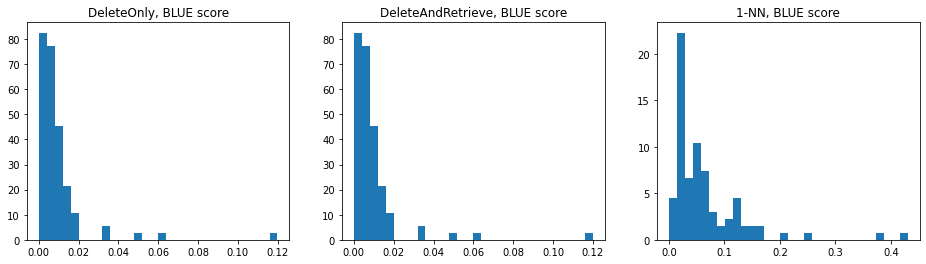

In [195]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16,4))     

plt.sca(ax[0])
plt.title('DeleteOnly, BLUE score')
plt.hist(pairwise_bleu, density=True, bins=30)

plt.sca(ax[1])
plt.title('DeleteAndRetrieve, BLUE score')
plt.hist(pairwise_bleu2, density=True, bins=30)

plt.sca(ax[2])
plt.title('1-NN, BLUE score')
plt.hist(pairwise_bleu3, density=True, bins=30)

plt.show()

### 4.4 Plot histograms of event count differences (modification counts)

In [196]:
# The counts of total, drug events and procedures, for the original sequences
original_counts = pd.DataFrame(columns=['total', 'drug', 'procedure'])

In [197]:
def get_counts_table(event_sequences):
    temp_list = list()
    for seq in event_sequences:
        splitted = seq.split()
        total = len(splitted)
        # MetaVision ITEMID values are all above 220000. Since this data only contains data from MetaVision, it only contains ITEMID above 220000
        drug = len([x for x in splitted if int(x)>=220000])
        procedure = total - drug

        temp_list.append({'total': total, 'drug': drug, 'procedure': procedure})
    
    return pd.DataFrame(temp_list)

In [198]:
df_original_counts = get_counts_table(original_event_sequences)

In [199]:
df_original_counts.head()

,total,drug,procedure
0,34,30,4
1,7,3,4
2,47,44,3
3,22,18,4
4,52,47,5


In [200]:
# Get count tables for all the tranformed results (generated counterfactuals)
trans_counts1 = get_counts_table(trans_event_sequences1)
trans_counts2 = get_counts_table(trans_event_sequences2)
trans_counts3 = get_counts_table(trans_event_sequences3)

In [201]:
# Substract the original counts to get event modifications for total, drug events and procedures
substracted1 = trans_counts1.subtract(df_original_counts)
substracted2 = trans_counts2.subtract(df_original_counts)
substracted3 = trans_counts3.subtract(df_original_counts)

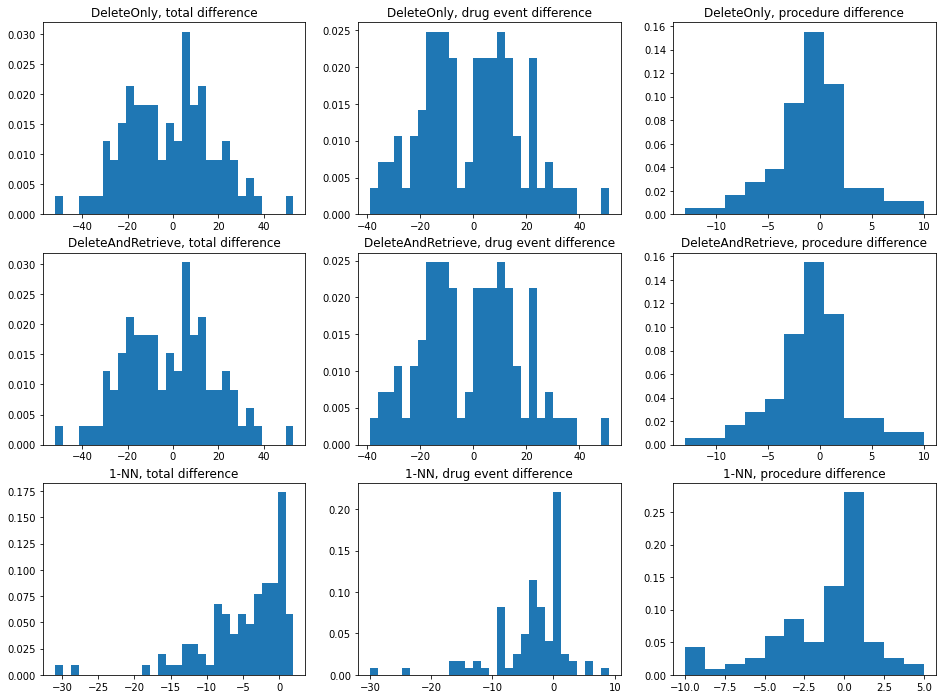

In [202]:
# Plot 3x3 subplots
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(16,12))

plt.sca(ax[0,0])
plt.title('DeleteOnly, total difference')
plt.hist(substracted1['total'], density=True, bins=30)

plt.sca(ax[0,1])
plt.title('DeleteOnly, drug event difference')
plt.hist(substracted1['drug'], density=True, bins=30)

plt.sca(ax[0,2])
plt.title('DeleteOnly, procedure difference')
plt.hist(substracted1['procedure'], density=True, bins=12)

plt.sca(ax[1,0])
plt.title('DeleteAndRetrieve, total difference')
plt.hist(substracted2['total'], density=True, bins=30)

plt.sca(ax[1,1])
plt.title('DeleteAndRetrieve, drug event difference')
plt.hist(substracted2['drug'], density=True, bins=30)

plt.sca(ax[1,2])
plt.title('DeleteAndRetrieve, procedure difference')
plt.hist(substracted2['procedure'], density=True, bins=12)

plt.sca(ax[2,0])
plt.title('1-NN, total difference')
plt.hist(substracted3['total'], density=True, bins=30)

plt.sca(ax[2,1])
plt.title('1-NN, drug event difference')
plt.hist(substracted3['drug'], density=True, bins=30)

plt.sca(ax[2,2])
plt.title('1-NN, procedure difference')
plt.hist(substracted3['procedure'], density=True, bins=12)

plt.show()

### 4.5 Export example counterfactuals 

In [203]:
# Convert id to original event name
conn = psycopg2.connect(
    database="mimic", 
    user='postgres',
    password=getpass.getpass("Enter postgres password"), 
    host="127.0.0.1", 
    port="5432",
    options=f'-c search_path=mimiciii')

In [204]:
# Get a mapping from itemid to name (drug events)
itemid_to_name = pd.read_sql(
    """
    SELECT itemid, abbreviation, label
    FROM d_items;
    """, conn)

itemid_to_name = itemid_to_name[itemid_to_name['itemid'] >= 220000]
itemid_to_name.head()

,itemid,abbreviation,label
8673,221015,Ensure,Ensure
8674,221016,Ensure Plus,Ensure Plus
8675,221017,"Dextrose 2,5%","Dextrose 2,5%"
8676,225166,Potassium Chloride - KCL,Potassium Chloride
8677,225167,Hydrochloric Acid - HCL,Hydrochloric Acid - HCL


In [205]:
# Get another mapping from procedure itemid to name 
itemid_to_name2 = pd.read_sql(
    """
    SELECT icd9_code, short_title, long_title
    FROM d_icd_procedures;
    """, conn)

itemid_to_name2.head()

,icd9_code,short_title,long_title
0,0851,Canthotomy,Canthotomy
1,0852,Blepharorrhaphy,Blepharorrhaphy
2,0859,Adjust lid position NEC,Other adjustment of lid position
3,0861,Lid reconst w skin graft,Reconstruction of eyelid with skin flap or graft
4,0862,Lid reconst w muc graft,Reconstruction of eyelid with mucous membrane ...


In [206]:
# Concate two itemid_to_name into one table
itemid_to_name2 = itemid_to_name2.rename(columns={'icd9_code': 'itemid', 'short_title': 'abbreviation', 'long_title': 'label'})

itemid_to_name_concat = pd.concat([itemid_to_name, itemid_to_name2])

In [207]:
# Convert data type to be consistent when filtering, e.g. 'itemid_to_name_concat['itemid'] == 9671'
itemid_to_name_concat['label'] = itemid_to_name_concat['label'].astype('str') 
itemid_to_name_concat['itemid'] = itemid_to_name_concat['itemid'].astype('int') 

In [208]:
# Define a method to convert event codes to original names
def code_to_name(event_sequence):
    code_sequence = [int(event) for event in event_sequence.split()]
    
    temp_list = list()
    for code in code_sequence:
        event_name = itemid_to_name_concat[itemid_to_name_concat['itemid'] == code]['label'].item()
        temp_list.append(event_name)
    
    return temp_list

In [209]:
# Get the sample for example counterfactuals
sample_id = 44

In [210]:
code_to_name(original_event_sequences[sample_id])

['Propofol',
 'Propofol',
 'Gastric Meds',
 'Morphine Sulfate',
 'Metoprolol',
 'Morphine Sulfate',
 'Morphine Sulfate',
 'Insertion of endotracheal tube']

In [211]:
# original_event_sequences[sample_id]

In [212]:
code_to_name(trans_event_sequences1[sample_id])

['Diltiazem',
 'Diltiazem',
 'Diltiazem',
 'Diltiazem',
 'Diltiazem',
 'Heparin Sodium (Prophylaxis)',
 'Diltiazem',
 'Diltiazem',
 'Diltiazem',
 'Diltiazem',
 'Diltiazem',
 'Diltiazem',
 'Diltiazem',
 'Diltiazem',
 'Diltiazem',
 'Calcium Gluconate',
 'Piggyback',
 'Calcium Gluconate',
 'Diltiazem',
 'Diltiazem',
 'Heparin Sodium (Prophylaxis)',
 'D5NS',
 'Calcium Gluconate',
 'Piggyback',
 'Dilantin',
 'Heparin Sodium (Prophylaxis)',
 'Dilantin',
 'Dilantin',
 'Metoprolol',
 'Heparin Sodium (Prophylaxis)',
 'Continuous invasive mechanical ventilation for less than 96 consecutive hours',
 'Bronchial dilation',
 'Other intubation of respiratory tract']

In [213]:
# trans_event_sequences1[sample_id]

In [214]:
code_to_name(trans_event_sequences2[sample_id])

['Diltiazem',
 'Diltiazem',
 'Diltiazem',
 'Diltiazem',
 'Diltiazem',
 'Heparin Sodium (Prophylaxis)',
 'Diltiazem',
 'Diltiazem',
 'Diltiazem',
 'Diltiazem',
 'Diltiazem',
 'Diltiazem',
 'Diltiazem',
 'Diltiazem',
 'Diltiazem',
 'Calcium Gluconate',
 'Piggyback',
 'Calcium Gluconate',
 'Diltiazem',
 'Diltiazem',
 'Heparin Sodium (Prophylaxis)',
 'D5NS',
 'Calcium Gluconate',
 'Piggyback',
 'Dilantin',
 'Heparin Sodium (Prophylaxis)',
 'Dilantin',
 'Dilantin',
 'Metoprolol',
 'Heparin Sodium (Prophylaxis)',
 'Continuous invasive mechanical ventilation for less than 96 consecutive hours',
 'Bronchial dilation',
 'Other intubation of respiratory tract']

In [215]:
# trans_event_sequences2[sample_id]

In [216]:
code_to_name(trans_event_sequences3[sample_id])

['D5 1/2NS',
 'Packed Red Blood Cells',
 'Packed Red Blood Cells',
 'Morphine Sulfate',
 'D5 1/2NS',
 'Morphine Sulfate',
 'Morphine Sulfate',
 'Closed reduction of fracture with internal fixation, femur']

In [217]:
# trans_event_sequences3[sample_id]